In [1]:
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import gc
from matplotlib.collections import LineCollection  # 新增导入LineCollection

habitat_current=xr.open_dataarray("habitat_maxent_current.nc")
habitat_585=xr.open_dataarray("habitat_maxent_ssp585dec100.nc")
habitat_sum=xr.open_dataarray("habitat_maxent_sum.nc")
PC31 = xr.open_dataset("polar_31_pred.nc")
PC42 = xr.open_dataset("polar_42_pred.nc")


PC31_his = PC31.where(PC31.Years <=2024, drop=True)
PC31_pred = PC31.where(PC31.Years >2024, drop=True)

PC42_his = PC42.where(PC42.Years <=2024, drop=True)
PC42_pred = PC42.where(PC42.Years >2024, drop=True)

habitat_maxent_current_regions=xr.open_dataset("habitat_maxent_current_regions.nc")
habitat_maxent_585_regions=xr.open_dataset("habitat_maxent_ssp585dec100_regions.nc")

# Clear PC31 and PC42 to free memory
del PC31, PC42

# Force garbage collection
gc.collect()

88

In [2]:
import numpy as np

# 定义所有需要处理的海区名称列表
region_names = [
    'barents_sea',
    'kara_sea',
    'laptev_sea',
    'east_siberian_sea',
    'chukchi_and_bering_sea',
    'beaufort_sea',
    'canadian_arctic',
    'baffin_bay',
    'atlantic_marginal',
    'center_arctic_and_ice_marginal',
    'whole_arctic'
]
# Define regions with their bounds
regions = {
    'barents_sea': {'lon_min': 20, 'lon_max': 55, 'lat_min': 60, 'lat_max': 75, 'name': 'Barents Sea'},
    'kara_sea': {'lon_min': 55, 'lon_max': 100, 'lat_min': 60, 'lat_max': 75, 'name': 'Kara Sea'},
    'laptev_sea': {'lon_min': 100, 'lon_max': 140, 'lat_min': 60, 'lat_max': 75, 'name': 'Laptev Sea'},
    'east_siberian_sea': {'lon_min': 140, 'lon_max': 170, 'lat_min': 60, 'lat_max': 75, 'name': 'East Siberian Sea'},
    'chukchi_and_bering_sea': {'lon_min': 170, 'lon_max': -160, 'lat_min': 60, 'lat_max': 75, 'name': 'Chukchi and Bering Sea'},
    'beaufort_sea': {'lon_min': -160, 'lon_max': -130, 'lat_min': 60, 'lat_max': 75, 'name': 'Beaufort Sea'},
    'canadian_arctic': {'lon_min': -130, 'lon_max': -80, 'lat_min': 60, 'lat_max': 75, 'name': 'Canadian Arctic Archipelago'},
    'baffin_bay': {'lon_min': -80, 'lon_max': -40, 'lat_min': 60, 'lat_max': 75, 'name': 'Baffin Bay'},
    'atlantic_marginal': {'lon_min': -40, 'lon_max': 20, 'lat_min': 60, 'lat_max': 75, 'name': 'Atlantic Marginal Seas'},
    'center_arctic_and_ice_marginal': {'lon_min': -180, 'lon_max': 180, 'lat_min': 75, 'lat_max': 90, 'name': 'Center Arctic and Sea Ice Marginal'},
}
# 限制数据值在0-100之间
PC31_his['mhw'] = PC31_his.mhw.clip(min=0, max=100)
PC31_his['nan'] = PC31_his.nan.clip(min=0, max=100)
PC31_pred['mhw'] = PC31_pred.mhw.clip(min=0, max=100)
PC31_pred['nan'] = PC31_pred.nan.clip(min=0, max=100)
PC42_his['mhw'] = PC42_his.mhw.clip(min=0, max=100)
PC42_his['nan'] = PC42_his.nan.clip(min=0, max=100)
PC42_pred['mhw'] = PC42_pred.mhw.clip(min=0, max=100)
PC42_pred['nan'] = PC42_pred.nan.clip(min=0, max=100)
habitat_maxent_current_regions = habitat_maxent_current_regions.assign_coords(
    Latitude=PC31_his.mhw.Latitude,
    Longitude=PC31_his.mhw.Longitude
)
habitat_maxent_585_regions = habitat_maxent_585_regions.assign_coords(
    Latitude=PC31_his.mhw.Latitude,
    Longitude=PC31_his.mhw.Longitude
)

# 创建权重计算函数（考虑纬度）

def weighted_mean(data, weights, dim):
    """计算加权平均值"""
    weighted_sum = (data * weights).sum(dim=dim)
    weights_sum = weights.where(~data.isnull()).sum(dim=dim)
    return weighted_sum / weights_sum

# 创建字典存储处理结果
PC31_his_region_mhw = {}
PC31_his_region_nan = {}
PC31_his_region_ano = {}
PC31_his_annual_mhw=PC31_his.mhw.mean(dim=['time'], skipna=True)
PC31_his_annual_nan=PC31_his.nan.mean(dim=['time'], skipna=True)
PC31_his_annual_ano=PC31_his_annual_mhw-PC31_his_annual_nan

# 计算纬度权重（地球曲率校正）
lat_radians = np.deg2rad(PC31_his_annual_mhw.Latitude)
weights = np.cos(lat_radians)

for region in region_names:
    # 从数据集中获取当前海区的掩膜数据
    habitat_mask = habitat_maxent_current_regions[region]
    
    # 应用掩膜并计算加权空间平均值
    masked_ano = PC31_his_annual_ano.where(habitat_mask.notnull())
    masked_mhw = PC31_his_annual_mhw.where(habitat_mask.notnull())
    masked_nan = PC31_his_annual_nan.where(habitat_mask.notnull())
    
    PC31_his_region_ano[region] = weighted_mean(
        masked_ano, weights, dim=['Latitude', 'Longitude']
    )
    PC31_his_region_mhw[region] = weighted_mean(
        masked_mhw, weights, dim=['Latitude', 'Longitude']
    )
    PC31_his_region_nan[region] = weighted_mean(
        masked_nan, weights, dim=['Latitude', 'Longitude']
    )

PC31_pred_region_mhw = {}
PC31_pred_region_nan = {}
PC31_pred_region_ano = {}
PC31_pred_annual_mhw=PC31_pred.mhw.mean(dim=['time'], skipna=True)
PC31_pred_annual_nan=PC31_pred.nan.mean(dim=['time'], skipna=True)
PC31_pred_annual_ano=PC31_pred_annual_mhw-PC31_pred_annual_nan

for region in region_names:
    # 从数据集中获取当前海区的掩膜数据
    habitat_mask = habitat_maxent_585_regions[region]
    
    # 应用掩膜并计算加权空间平均值
    masked_ano = PC31_pred_annual_ano.where(habitat_mask.notnull())
    masked_mhw = PC31_pred_annual_mhw.where(habitat_mask.notnull())
    masked_nan = PC31_pred_annual_nan.where(habitat_mask.notnull())
    
    PC31_pred_region_ano[region] = weighted_mean(
        masked_ano, weights, dim=['Latitude', 'Longitude']
    )
    PC31_pred_region_mhw[region] = weighted_mean(
        masked_mhw, weights, dim=['Latitude', 'Longitude']
    )
    PC31_pred_region_nan[region] = weighted_mean(
        masked_nan, weights, dim=['Latitude', 'Longitude']
    )


/tmp/ipykernel_332669/3874304160.py:142: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r.replace('_', ' ').title() for r in region_names],


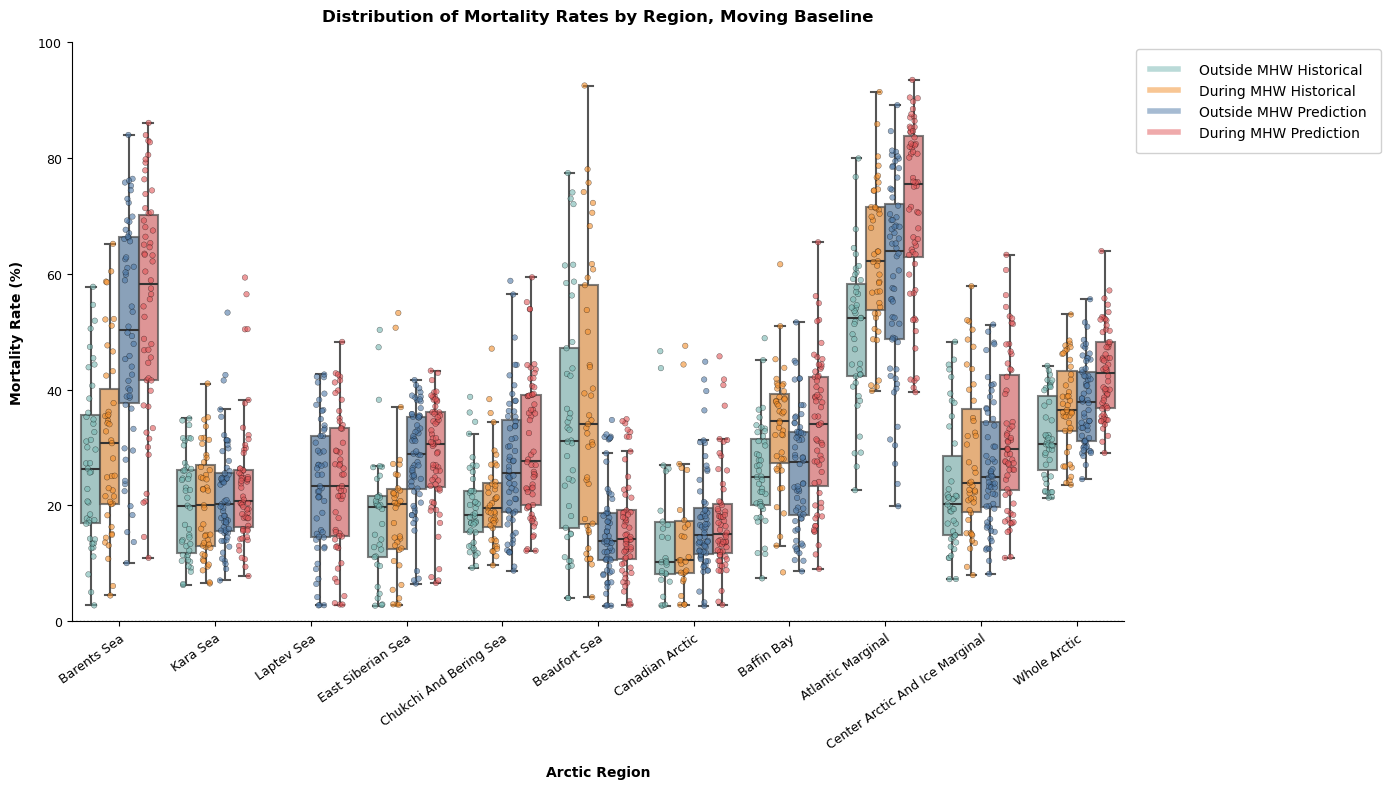

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a list to store all the data points
data_for_plot = []

# Process historical non-MHW data (first)
for region, data in PC31_his_region_nan.items():
    # Extract years and values
    years = data.Years.values
    values = data.values
    
    # Convert to dataframe rows
    region_data = pd.DataFrame({
        'Region': region,
        'Year': years,
        'Anomaly': values,
        'Period': 'Historical',
        'Type': 'Non-MHW'
    })
    
    data_for_plot.append(region_data)

# Process historical MHW data (second)
for region, data in PC31_his_region_mhw.items():
    # Extract years and values
    years = data.Years.values
    values = data.values
    
    # Convert to dataframe rows
    region_data = pd.DataFrame({
        'Region': region,
        'Year': years,
        'Anomaly': values,
        'Period': 'Historical',
        'Type': 'MHW'
    })
    
    data_for_plot.append(region_data)

# Process prediction non-MHW data (third)
for region, data in PC31_pred_region_nan.items():
    # Extract years and values
    years = data.Years.values
    values = data.values
    
    # Convert to dataframe rows
    region_data = pd.DataFrame({
        'Region': region,
        'Year': years,
        'Anomaly': values,
        'Period': 'Prediction',
        'Type': 'Non-MHW'
    })
    
    data_for_plot.append(region_data)

# Process prediction MHW data (fourth)
for region, data in PC31_pred_region_mhw.items():
    # Extract years and values
    years = data.Years.values
    values = data.values
    
    # Convert to dataframe rows
    region_data = pd.DataFrame({
        'Region': region,
        'Year': years,
        'Anomaly': values,
        'Period': 'Prediction',
        'Type': 'MHW'
    })
    
    data_for_plot.append(region_data)

# Concatenate all data into one DataFrame
df_plot = pd.concat(data_for_plot, ignore_index=True)

# 设置绘图参数
plt.rcParams.update({
    'font.sans-serif': ['DejaVu Sans', 'Arial'],
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'axes.labelweight': 'bold'
})

# 创建画布
fig, ax = plt.subplots(figsize=(14, 8))
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.15)

# Define colors for each combination
colors = {
    ('Historical', 'Non-MHW'): '#76B7B2', # Teal
    ('Historical', 'MHW'): '#F28E2B',    # Orange
    ('Prediction', 'Non-MHW'): '#4E79A7',    # Blue
    ('Prediction', 'MHW'): '#E15759'  # Red
}

# Convert Period and Type to a combined category for coloring
df_plot['Category'] = df_plot.apply(lambda x: f"{x['Period']}_{x['Type']}", axis=1)

# Create custom palette
box_order = ['Historical_Non-MHW', 'Historical_MHW', 'Prediction_Non-MHW', 'Prediction_MHW']
palette = [colors[('Historical', 'Non-MHW')], colors[('Historical', 'MHW')], 
           colors[('Prediction', 'Non-MHW')], colors[('Prediction', 'MHW')]]

# 绘制箱线图
boxplot = sns.boxplot(
    x='Region', y='Anomaly', hue='Category',
    data=df_plot, palette=palette,
    hue_order=box_order,
    width=0.8, linewidth=1.5,
    flierprops={'marker': ''},  # 不显示异常值
    whiskerprops=dict(color='#555555', linewidth=1.5),
    capprops=dict(color='#555555', linewidth=1.5),
    medianprops=dict(color='#333333', linewidth=1.5),
    boxprops=dict(alpha=0.7),
    ax=ax,
    zorder=0
)

# 绘制散点图（先绘制）
stripplot = sns.stripplot(
    x='Region', y='Anomaly', hue='Category',
    data=df_plot, palette=palette,
    hue_order=box_order,
    dodge=True, alpha=0.6, jitter=0.2,
    size=4, edgecolor='k', linewidth=0.3,
    zorder=1, legend=False
)

# 优化坐标轴标签
ax.set_title('Distribution of Mortality Rates by Region, Moving Baseline',
            fontsize=12, pad=15, fontweight='bold')
ax.set_xlabel('Arctic Region', labelpad=10)
ax.set_ylabel('Mortality Rate (%)', labelpad=10)
ax.set_ylim(0, 100)  # 设置y轴范围
# 优化刻度标签
ax.set_xticklabels([r.replace('_', ' ').title() for r in region_names],
                  rotation=35, ha='right', rotation_mode='anchor')

# 添加参考线
ax.axhline(0, color='#666666', linestyle=':', linewidth=1, zorder=0)

# 智能图例配置
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=colors[('Historical', 'Non-MHW')], lw=4, alpha=0.5, label='Outside MHW Historical '),
    Line2D([0], [0], color=colors[('Historical', 'MHW')], lw=4, alpha=0.5, label='During MHW Historical'),
    Line2D([0], [0], color=colors[('Prediction', 'Non-MHW')], lw=4, alpha=0.5, label='Outside MHW Prediction'),
    Line2D([0], [0], color=colors[('Prediction', 'MHW')], lw=4, alpha=0.5, label='During MHW Prediction')
]
ax.legend(handles=legend_elements, 
         frameon=True, framealpha=0.9,
         borderpad=1, handletextpad=1.5,
         loc='upper right', bbox_to_anchor=(1.25, 1))

sns.despine()
plt.tight_layout()

# 保存输出
plt.savefig('figures/PC31_mortality_rate_comparison.png', 
           dpi=400, bbox_inches='tight', transparent=False)
plt.show()

In [4]:
# 创建字典存储处理结果
PC42_his_region_mhw = {}
PC42_his_region_nan = {}
PC42_his_region_ano = {}
PC42_his_annual_mhw=PC42_his.mhw.mean(dim=['time'], skipna=True)
PC42_his_annual_nan=PC42_his.nan.mean(dim=['time'], skipna=True)
PC42_his_annual_ano=PC42_his_annual_mhw-PC42_his_annual_nan

# 计算纬度权重（地球曲率校正）
lat_radians = np.deg2rad(PC42_his_annual_mhw.Latitude)
weights = np.cos(lat_radians)

for region in region_names:
    # 从数据集中获取当前海区的掩膜数据
    habitat_mask = habitat_maxent_current_regions[region]
    
    # 应用掩膜并计算加权空间平均值
    masked_ano = PC42_his_annual_ano.where(habitat_mask.notnull())
    masked_mhw = PC42_his_annual_mhw.where(habitat_mask.notnull())
    masked_nan = PC42_his_annual_nan.where(habitat_mask.notnull())
    
    PC42_his_region_ano[region] = weighted_mean(
        masked_ano, weights, dim=['Latitude', 'Longitude']
    )
    PC42_his_region_mhw[region] = weighted_mean(
        masked_mhw, weights, dim=['Latitude', 'Longitude']
    )
    PC42_his_region_nan[region] = weighted_mean(
        masked_nan, weights, dim=['Latitude', 'Longitude']
    )

PC42_pred_region_mhw = {}
PC42_pred_region_nan = {}
PC42_pred_region_ano = {}
PC42_pred_annual_mhw=PC42_pred.mhw.mean(dim=['time'], skipna=True)
PC42_pred_annual_nan=PC42_pred.nan.mean(dim=['time'], skipna=True)
PC42_pred_annual_ano=PC42_pred_annual_mhw-PC42_pred_annual_nan

for region in region_names:
    # 从数据集中获取当前海区的掩膜数据
    habitat_mask = habitat_maxent_585_regions[region]
    
    # 应用掩膜并计算加权空间平均值
    masked_ano = PC42_pred_annual_ano.where(habitat_mask.notnull())
    masked_mhw = PC42_pred_annual_mhw.where(habitat_mask.notnull())
    masked_nan = PC42_pred_annual_nan.where(habitat_mask.notnull())
    
    PC42_pred_region_ano[region] = weighted_mean(
        masked_ano, weights, dim=['Latitude', 'Longitude']
    )
    PC42_pred_region_mhw[region] = weighted_mean(
        masked_mhw, weights, dim=['Latitude', 'Longitude']
    )
    PC42_pred_region_nan[region] = weighted_mean(
        masked_nan, weights, dim=['Latitude', 'Longitude']
    )


/tmp/ipykernel_332669/3875509566.py:142: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r.replace('_', ' ').title() for r in region_names],


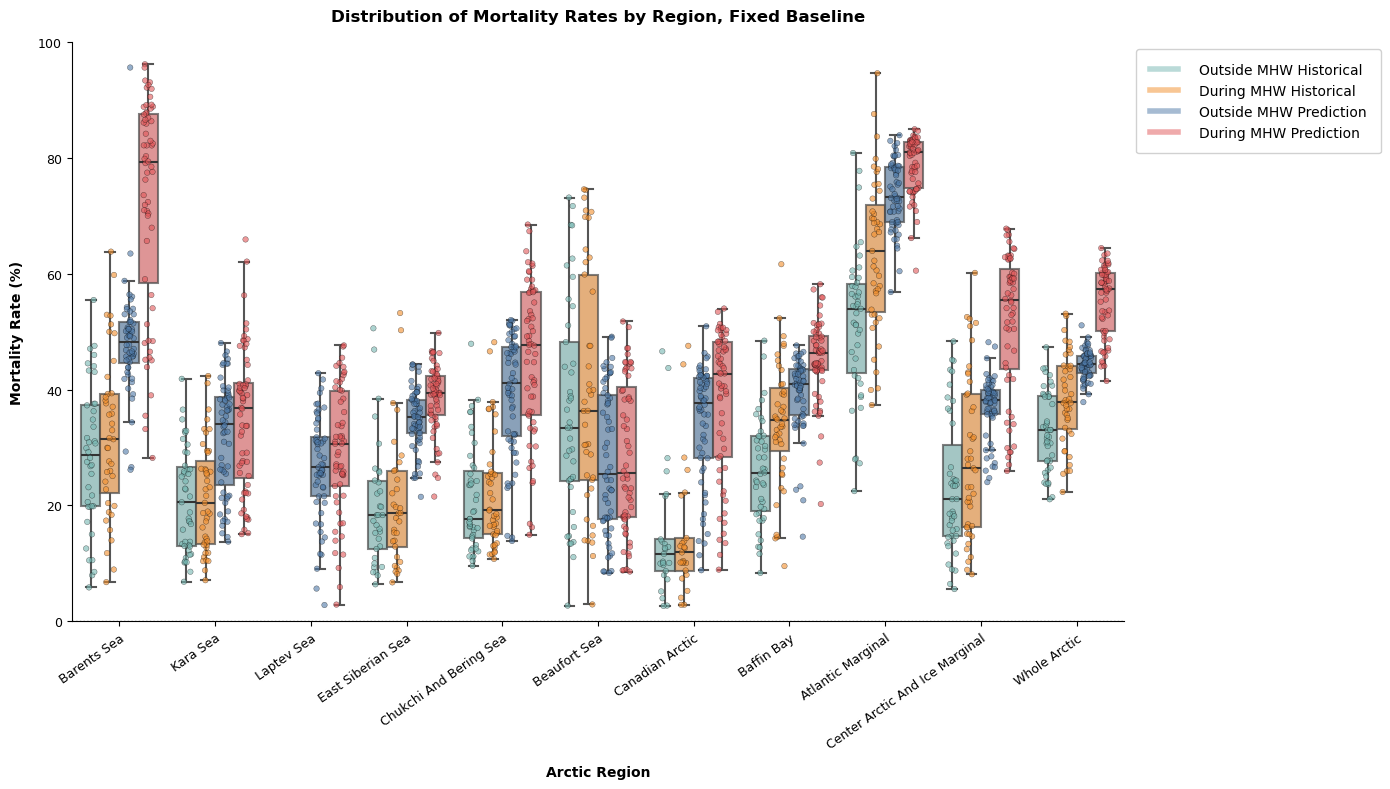

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a list to store all the data points
data_for_plot = []

# Process historical non-MHW data (first)
for region, data in PC42_his_region_nan.items():
    # Extract years and values
    years = data.Years.values
    values = data.values
    
    # Convert to dataframe rows
    region_data = pd.DataFrame({
        'Region': region,
        'Year': years,
        'Anomaly': values,
        'Period': 'Historical',
        'Type': 'Non-MHW'
    })
    
    data_for_plot.append(region_data)

# Process historical MHW data (second)
for region, data in PC42_his_region_mhw.items():
    # Extract years and values
    years = data.Years.values
    values = data.values
    
    # Convert to dataframe rows
    region_data = pd.DataFrame({
        'Region': region,
        'Year': years,
        'Anomaly': values,
        'Period': 'Historical',
        'Type': 'MHW'
    })
    
    data_for_plot.append(region_data)

# Process prediction non-MHW data (third)
for region, data in PC42_pred_region_nan.items():
    # Extract years and values
    years = data.Years.values
    values = data.values
    
    # Convert to dataframe rows
    region_data = pd.DataFrame({
        'Region': region,
        'Year': years,
        'Anomaly': values,
        'Period': 'Prediction',
        'Type': 'Non-MHW'
    })
    
    data_for_plot.append(region_data)

# Process prediction MHW data (fourth)
for region, data in PC42_pred_region_mhw.items():
    # Extract years and values
    years = data.Years.values
    values = data.values
    
    # Convert to dataframe rows
    region_data = pd.DataFrame({
        'Region': region,
        'Year': years,
        'Anomaly': values,
        'Period': 'Prediction',
        'Type': 'MHW'
    })
    
    data_for_plot.append(region_data)

# Concatenate all data into one DataFrame
df_plot = pd.concat(data_for_plot, ignore_index=True)

# 设置绘图参数
plt.rcParams.update({
    'font.sans-serif': ['DejaVu Sans', 'Arial'],
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'axes.labelweight': 'bold'
})

# 创建画布
fig, ax = plt.subplots(figsize=(14, 8))
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.15)

# Define colors for each combination
colors = {
    ('Historical', 'Non-MHW'): '#76B7B2', # Teal
    ('Historical', 'MHW'): '#F28E2B',    # Orange
    ('Prediction', 'Non-MHW'): '#4E79A7',    # Blue
    ('Prediction', 'MHW'): '#E15759'  # Red
}

# Convert Period and Type to a combined category for coloring
df_plot['Category'] = df_plot.apply(lambda x: f"{x['Period']}_{x['Type']}", axis=1)

# Create custom palette
box_order = ['Historical_Non-MHW', 'Historical_MHW', 'Prediction_Non-MHW', 'Prediction_MHW']
palette = [colors[('Historical', 'Non-MHW')], colors[('Historical', 'MHW')], 
           colors[('Prediction', 'Non-MHW')], colors[('Prediction', 'MHW')]]

# 绘制箱线图
boxplot = sns.boxplot(
    x='Region', y='Anomaly', hue='Category',
    data=df_plot, palette=palette,
    hue_order=box_order,
    width=0.8, linewidth=1.5,
    flierprops={'marker': ''},  # 不显示异常值
    whiskerprops=dict(color='#555555', linewidth=1.5),
    capprops=dict(color='#555555', linewidth=1.5),
    medianprops=dict(color='#333333', linewidth=1.5),
    boxprops=dict(alpha=0.7),
    ax=ax,
    zorder=0
)

# 绘制散点图（先绘制）
stripplot = sns.stripplot(
    x='Region', y='Anomaly', hue='Category',
    data=df_plot, palette=palette,
    hue_order=box_order,
    dodge=True, alpha=0.6, jitter=0.2,
    size=4, edgecolor='k', linewidth=0.3,
    zorder=1, legend=False
)

# 优化坐标轴标签
ax.set_title('Distribution of Mortality Rates by Region, Fixed Baseline',
            fontsize=12, pad=15, fontweight='bold')
ax.set_xlabel('Arctic Region', labelpad=10)
ax.set_ylabel('Mortality Rate (%)', labelpad=10)
ax.set_ylim(0, 100)  # 设置y轴范围
# 优化刻度标签
ax.set_xticklabels([r.replace('_', ' ').title() for r in region_names],
                  rotation=35, ha='right', rotation_mode='anchor')

# 添加参考线
ax.axhline(0, color='#666666', linestyle=':', linewidth=1, zorder=0)

# 智能图例配置
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=colors[('Historical', 'Non-MHW')], lw=4, alpha=0.5, label='Outside MHW Historical '),
    Line2D([0], [0], color=colors[('Historical', 'MHW')], lw=4, alpha=0.5, label='During MHW Historical'),
    Line2D([0], [0], color=colors[('Prediction', 'Non-MHW')], lw=4, alpha=0.5, label='Outside MHW Prediction'),
    Line2D([0], [0], color=colors[('Prediction', 'MHW')], lw=4, alpha=0.5, label='During MHW Prediction')
]
ax.legend(handles=legend_elements, 
         frameon=True, framealpha=0.9,
         borderpad=1, handletextpad=1.5,
         loc='upper right', bbox_to_anchor=(1.25, 1))

sns.despine()
plt.tight_layout()

# 保存输出
plt.savefig('figures/PC42_mortality_rate_comparison.png', 
           dpi=400, bbox_inches='tight', transparent=False)
plt.show()